In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [2]:
labels = pd.read_csv("Datasets/celeba/labels.csv", index_col=0, sep='\t')

labels.head()

,img_name,gender,smiling
0,0.jpg,-1,1
1,1.jpg,-1,1
2,2.jpg,1,-1
3,3.jpg,-1,-1
4,4.jpg,-1,-1


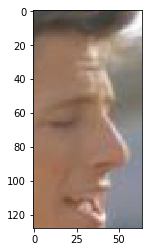

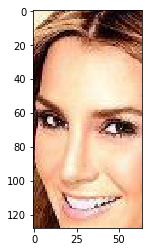

In [32]:
# Function to get and preprocess(crop or resize) the images
def resize_get_image(row_id, root="Datasets/celeba/img"):
    # Open Image
    file_name = "{}.jpg".format(row_id)
    file_path = os.path.join(root, file_name)
    img_ori = Image.open(file_path)
    
    # Cropped Image Parameters(Assuming all faces are in the middle 64x128)
    left, right = 57, 121
    top, bot = 45, 173
    img_resize = img_ori.crop((left, top, right, bot))
    
    return np.array(img_resize)
# Testing Example - Male
male_row = labels[labels.gender == 1].index[0]
plt.imshow(resize_get_image(male_row))
plt.show()

# Testing Example - Female
female_row = labels[labels.gender == -1].index[0]
plt.imshow(resize_get_image(female_row))
plt.show()

Color Male image has shape:  (128, 64, 3)
Greyscale male imge has shape (128, 64)


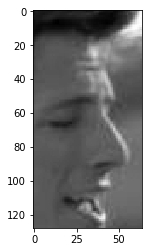

In [33]:
male = resize_get_image(male_row)
print("Color Male image has shape: ", male.shape)

male_grey = rgb2grey(male)
plt.imshow(male_grey, cmap=mpl.cm.gray)
print("Greyscale male imge has shape", male_grey.shape)

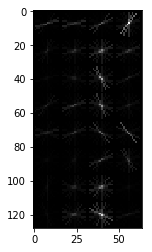

In [34]:
hog_features, hog_image = hog(male_grey, 
                              visualise=True,
                              block_norm="L2-Hys",
                              pixels_per_cell=(16,16))
plt.imshow(hog_image, cmap = mpl.cm.gray)

In [35]:
def create_features(img):
    color_features = img.flatten()
    img_grey = rgb2grey(img)
    hog_feartures = hog(img_grey, block_norm="L2-Hys", pixels_per_cell=(16,16),cells_per_block=(2,2))
    flat_features = np.hstack(color_features)
    return flat_features

# Testing Example - male
male_features = create_features(male)
print(male_features)

[ 79  79  77 ... 107 120 137]


In [41]:
# Preprocessing the features
def create_feature_matrix(label_dataframe):
    feature_list = []
    i = 0
    for img_id in label_dataframe.index:
        img = resize_get_image(img_id)
        image_features = create_features(img)
        feature_list.append(image_features)
        if(i % 1000 == 0):
            print("Done: ", i)
        i+=1
    
    feature_matrix = np.array(feature_list)
    return feature_matrix

feature_matrix = create_feature_matrix(labels)

Done:  0
Done:  1000
Done:  2000
Done:  3000
Done:  4000


In [42]:
print("Feature Matrix Shape is: ", feature_matrix.shape)

ss = StandardScaler()
people_stand = ss.fit_transform(feature_matrix)

pca = PCA()
people_pca = ss.fit_transform(people_stand)
print("PCA Matrix Shape is: ", people_pca.shape)

Feature Matrix Shape is:  (5000, 24576)


/Users/Rawtimmy/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


PCA Matrix Shape is:  (5000, 24576)


# Gender Classification

In [43]:
X = pd.DataFrame(people_pca)
y = pd.Series(labels.gender.values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=1234123)

pd.Series(y_train).value_counts()

-1    1782
 1    1718
dtype: int64

In [44]:
svm = SVC(kernel='linear', probability=True, random_state=42)
gender_model = svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [45]:
y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy is: ", accuracy)

Model Accuracy is:  0.8973333333333333


# Smiling Classification

In [46]:
X_smile = pd.DataFrame(people_pca)
y_smile = pd.Series(labels.smiling.values)
X_smile_train, X_smile_test, y_smile_train, y_smile_test = train_test_split(X_smile, y_smile, test_size = .3, random_state=1234123)

pd.Series(y_smile_train).value_counts()

-1    1753
 1    1747
dtype: int64

In [54]:
svm_smile = SVC(kernel='linear', probability=True, random_state=42)
smile_model = svm_smile.fit(X_smile_train, y_smile_train)

In [48]:
y_smile_pred = svm_smile.predict(X_smile_test)

accuracy_smile = accuracy_score(y_smile_test, y_smile_pred)
print("Model Accuracy is: ", accuracy_smile)

Model Accuracy is:  0.8466666666666667


# Scoring

In [51]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_smile_test, y_smile_pred)

0.8466748801314155

In [53]:
from sklearn.metrics import classification_report

target_names = ["Male", "Female"]
print(classification_report(y_smile_test, y_smile_pred, target_names = target_names))

             precision    recall  f1-score   support

       Male       0.84      0.85      0.85       747
     Female       0.85      0.84      0.85       753

avg / total       0.85      0.85      0.85      1500



In [56]:
smile_model.score(X_smile_train, y_smile_train)

1.0